In [251]:
import os
import csv
import json
import ast
from collections import Counter
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../"))

/Users/divyam/Dev/Data_Science/DSF_Project/AcademicPaperRanking
['AcademicPaperRanking', '2004_data.json', '.DS_Store', 'dblp.csv', 'sys_argv.py', '2005_data.json', 'common_progress_kernel.ipynb', 'acm.csv', '2006_data.json', 'dblp.txt', 'aminer_papers_0.zip', 'acm.txt', 'acm_data_processing.py', 'processedmagdata']


In [ ]:
def clean_data(df):
    #since first column contains row number
#     df.drop(["Row_num"], axis=1)
    #removing  and kesEntityId as simillar fields are already present
    df = df.drop(columns=["Row_num","kesEntityId"],axis=1)
    df["Popularity"] = df["Popularity"].apply(pd.to_numeric,downcast='float')
    df["Year"] = df["Year"].apply(pd.to_numeric,downcast='unsigned')
    df["Month"] = df["Month"].apply(pd.to_numeric,downcast='unsigned')
    df = df.dropna(subset=['Venue'])
    return df

In [3]:
# df_pub = pd.read_csv("../input/scopus-data/ProcessedScopusData.csv")
# If this doesn't work, please change it to the path where the file is locaed in your PC
df_pub = pd.read_csv("Data/ProcessedScopusData.csv")

In [4]:
df_pub.head(5)

,Unnamed: 0,Scopus SourceID,Title,CiteScore,Percentile,Citation Count,Scholarly Output,Percent Cited,SNIP,SJR,...,Type,OpenAccess,Scopus ASJC Code (Sub-subject Area),Scopus Sub-Subject Area,Quartile,Top 10% (CiteScore Percentile),Scopus SourceID.1,Print-ISSN,E-ISSN,Subject Area
0,0,28773.0,Ca-A Cancer Journal for Clinicians,130.47,99.0,16961.0,130.0,70.0,88.164,61.786,...,Journal,NO,2720.0,Hematology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/28773,00079235,15424863,Medicine
1,1,28773.0,Ca-A Cancer Journal for Clinicians,130.47,99.0,16961.0,130.0,70.0,88.164,61.786,...,Journal,NO,2730.0,Oncology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/28773,00079235,15424863,Medicine
2,2,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,2713.0,Epidemiology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Medicine
3,3,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,3306.0,Health(social science),Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Social Sciences
4,4,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,2307.0,"Health, Toxicology and Mutagenesis",Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Environmental Science


In [5]:
df_pub.isna().sum()

Unnamed: 0                             0
Scopus SourceID                        0
Title                                  0
CiteScore                              0
Percentile                             0
Citation Count                         0
Scholarly Output                       0
Percent Cited                          0
SNIP                                   0
SJR                                    0
RANK                                   0
Rank Out Of                            0
Publisher                              0
Type                                   0
OpenAccess                             0
Scopus ASJC Code (Sub-subject Area)    0
Scopus Sub-Subject Area                0
Quartile                               0
Top 10% (CiteScore Percentile)         0
Scopus SourceID.1                      0
Print-ISSN                             0
E-ISSN                                 0
Subject Area                           0
dtype: int64

In [ ]:
def append_pub_score(df):
    print("Unique Publications from Scopus:",len(df_pub.Title.unique()))
    # Analysing Common Publications
    vfn_list = df.Venue.unique().tolist()
    scopus_list = df_pub.Title.unique().tolist()
    count = 0
    for pub in scopus_list:
        if pub in vfn_list:
            count +=1
    print("Publications present in Dataset:",count)
    print("Shape Before",df.shape)
    df = df[df.Venue.isin(scopus_list)]
    print("Shape After",df.shape)
    #score appending
    score_dict = pd.Series(df_pub.SJR.values,index=df_pub.Title).to_dict()
    df["Publication_Rank"] = df.apply(lambda row: score_dict[row["Venue"]],axis = 1)
    return df

def extract_field(row):
    val = row["Domain"]
    index = val.rfind("FN")
    val = val[index+3:len(val)]
    val = val.strip(":}] '")
    return val

def get_num_authors(row):
    vals = row["Authors"].split("},")
    return len(vals)

In [ ]:
label_dict = {"C":0,"J":1,"CJ":2,"O":3}
def find_conference_type(row):
    if pd.isnull(row["Conference"]) and pd.isnull(row["Journal"]):
        return label_dict["O"]
    elif pd.isnull(row["Conference"]):
        return label_dict["J"]
    elif pd.isnull(row["Journal"]):
        return label_dict["C"]
    else:
        return label_dict["CJ"]

In [ ]:
def tidy_split(df, column, sep='|', keep=False):
    indexes = list()
    id_values = list()
    name_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            id_values.append(presplit)
        for value in values:
            indexes.append(i)
            val = value
            index1 = val.find("AuId")
            index2 = val.find("AfN")
            index3 = val.find("'S'")
            if index3 < index1:
                val = val[index1+4:index2]
                val = val.strip("', :")
            else:
                val = val[index1+4:index3]
                val = val.strip("', :")                
            id_values.append(val)
            index1 = value.find("AuN")
            val = value[index1+3:]
            val = val.strip("': }]")
            name_values.append(val)
    new_df = df.iloc[indexes, :].copy()
    new_df[column+"_Id"] = id_values
    new_new_df = new_df.iloc[:, :].copy()
    new_new_df[column+"_Name"] = name_values
    return new_new_df

In [ ]:
def process_year(df):
    # Make more sensible column names
    rename_dict = {"AA": "Authors", 
                   "C": "Conference", 
                   "CC": "Citation_count",
                   "ECC": "Expected_count",
                   "D": "Date", 
                   "F": "Domain", 
                   "J": "Journal", 
                   "RId": "References", 
                   "Ti": "Title", 
                   "VFN": "Venue", 
                   "W": "Words", 
                   "Y": "Year", 
                   "logprob":"Popularity",
                   "Unnamed: 0": "Row_num"}
    df.rename(index=str, columns=rename_dict, inplace=True)
    df.drop_duplicates(subset=['Title'], inplace=True)
    df["Month"] = pd.to_datetime(df["Date"]).dt.month
    df = clean_data(df)
    df = append_pub_score(df)
    df["Publication Type"] = df.apply(lambda row:find_conference_type(row),axis=1)
    df["Number_Of_authors"] = df.apply(lambda row:get_num_authors(row), axis = 1)
    return df

In [ ]:
# df = pd.read_csv("../input/mag-2007/mag_2007.csv")

In [ ]:
# df = process_year(df)

In [ ]:
# df.to_csv("mag_2007_processed.csv")

In [272]:
print(os.listdir("../processedmagdata"))

['mag_2016_processed.csv', 'mag_2012_processed.csv', 'mag_2015_processed.csv', 'mag_2011_processed.csv', 'mag_2008_processed.csv', 'mag_2018_processed.csv', 'mag_2009_processed.csv', 'mag_2007_processed.csv', 'mag_2010_processed.csv', 'mag_2014_processed.csv', 'mag_2013_processed.csv', 'mag_2017_processed.csv']


In [283]:
# to load just 1 year
df = pd.read_csv("../processedmagdata/mag_2017_processed.csv")

In [23]:
columns = ['Unnamed: 0','Authors', 'Conference','Citation_count','Date','Expected_count','Domain','Id','Journal','References','Title','Venue','Words','Year','Popularity','Month','Publication_Rank','Publication Type','Number_Of_authors']

In [285]:
sorted(os.listdir(path))

['mag_2007_processed.csv',
 'mag_2008_processed.csv',
 'mag_2009_processed.csv',
 'mag_2010_processed.csv',
 'mag_2011_processed.csv',
 'mag_2012_processed.csv',
 'mag_2013_processed.csv',
 'mag_2014_processed.csv',
 'mag_2015_processed.csv',
 'mag_2016_processed.csv',
 'mag_2017_processed.csv',
 'mag_2018_processed.csv']

In [321]:
df = pd.DataFrame(columns = columns)
# please give a path that works on your machine. Keep all the processed files in this path
path = "../processedmagdata/"
# for file in os.listdir(path):
paths = [
    'mag_2007_processed.csv',
    'mag_2008_processed.csv',
    'mag_2009_processed.csv',
    'mag_2010_processed.csv',
    'mag_2011_processed.csv',
    'mag_2012_processed.csv',
    'mag_2014_processed.csv',
    'mag_2015_processed.csv',
    'mag_2016_processed.csv',
    'mag_2017_processed.csv',
    'mag_2018_processed.csv']
for file in paths:
#     print(file)
    df_temp = pd.read_csv(path+"/"+file)
    df = df.append(df_temp, ignore_index=True)

In [322]:
df

,Unnamed: 0,Authors,Conference,Citation_count,Date,Expected_count,Domain,Id,Journal,References,Title,Venue,Words,Year,Popularity,Month,Publication_Rank,Publication Type,Number_Of_authors
0,0,"[{'AuId': 2077177608, 'S': 1, 'AuN': 'a k geim...",NaN,32455,2007-03-01,32455,"[{'FId': 2776443344, 'FN': 'graphene antenna'}...",2014935324,"{'JN': 'nat mater', 'JId': 103895331}","[2058122340, 2125284466, 2101977779, 213633433...",the rise of graphene,Nature Materials,"['graphene', 'rise']",2007,-13.939,3,18.263,1,2
1,1,"[{'S': 1, 'AuId': 2164450181, 'AfN': 'arizona ...",NaN,31972,2007-04-18,31972,"[{'FId': 2779695215, 'FN': 'methanococcoides'}...",2125121305,"{'JN': 'mol biol evol', 'JId': 57552105}","[2106882534, 2146396346, 2097706568, 212167786...",mega4 molecular evolutionary genetics analysis...,Molecular Biology and Evolution,"['0', '4', 'evolutionary', 'genetics', 'mega',...",2007,-13.987,4,5.475,1,5
2,8,"[{'AuId': 2021634522, 'S': 1, 'AuN': 'jorgen v...",NaN,11931,2007-09-15,11931,"[{'FId': 2778067265, 'FN': 'fluticasone furoat...",2127951128,"{'JN': 'amer j respir crit care med', 'JId': 9...","[2037377025, 2125078269, 2054931962, 158332766...",global strategy for the diagnosis management a...,American Journal of Respiratory and Critical C...,"['chronic', 'diagnosis', 'disease', 'executive...",2007,-14.603,9,5.942,1,13
3,9,"[{'S': 1, 'AuId': 2076027038, 'AfN': 'massachu...",NaN,15997,2007-09-01,15997,"[{'FId': 194139352, 'FN': 'imputation'}, {'FId...",2161633633,"{'JN': 'amer j hum genet', 'JId': 134425043}","[2110065044, 2076983043, 2162530578, 209812659...",plink a tool set for whole genome association ...,American Journal of Human Genetics,"['analyses', 'association', 'genome', 'linkage...",2007,-14.608,9,7.450,1,18
4,12,"[{'S': 1, 'AuId': 2559180283, 'AfN': 'european...",NaN,22014,2007-11-01,22014,"[{'FId': 169485995, 'FN': 'file transfer proto...",2137015675,"{'JN': 'bioinformatics', 'JId': 52395412}","[2106882534, 2097382368, 2132926880, 212777499...",clustal w and clustal x version 2 0,Bioinformatics,"['0', '2', 'clustal', 'version', 'w', 'x']",2007,-14.663,11,6.140,1,13
5,16,"[{'S': 1, 'AuId': 2192934902, 'AfN': 'kyoto un...",NaN,16037,2007-11-01,16037,"[{'FId': 23416140, 'FN': 'kosr'}, {'FId': 1841...",2138977668,"{'JN': 'cell', 'JId': 110447773}","[2125987139, 2086943348, 2053911973, 201003197...",induction of pluripotent stem cells from adult...,Cell,"['adult', 'cells', 'defined', 'factors', 'fibr...",2007,-14.768,11,25.137,1,7
6,17,"[{'S': 1, 'AuId': 1908413421, 'AfN': 'universi...",NaN,20192,2007-05-01,20192,"[{'FId': 2779004888, 'FN': 'rendaku'}, {'FId':...",2087484885,"{'JN': 'behav res methods', 'JId': 137478622}","[2037124948, 2150290224, 2107031757, 206952344...",g power 3 a flexible statistical power analysi...,Behavior Research Methods,"['3', 'behavioral', 'biomedical', 'flexible', ...",2007,-14.847,5,2.099,1,4
7,23,"[{'S': 1, 'AuId': 2012879206, 'AfN': 'universi...",NaN,7133,2007-06-07,7133,"[{'FId': 194139352, 'FN': 'imputation'}, {'FId...",2134783591,"{'JN': 'nature', 'JId': 137773608}","[2098126593, 2155121555, 2217809488, 215775270...",genome wide association study of 14 000 cases ...,Nature,"['000', '14', '3', 'association', 'common', 'c...",2007,-15.011,6,17.875,1,196
8,28,"[{'S': 1, 'AuId': 2130487111, 'AfN': 'harvard ...",NaN,12530,2007-07-12,12530,"[{'FId': 2779770214, 'FN': 'pediatric ependymo...",2160382843,"{'JN': 'acta neuropathol', 'JId': 198620474}","[2025504334, 1558421206, 1560814177, 215892299...",the 2007 who classification of tumours of the ...,Acta Neuropathologica,"['2007', 'central', 'classification', 'nervous...",2007,-15.041,7,7.589,1,8
9,42,"[{'S': 1, 'AuId': 2345235933, 'AfN': 'universi...",NaN,9964,2007-10-01,9964,"[{'FId': 2779638118, 'FN': 'strengthening the ...",2275737843,"{'JN': 'lancet', 'JId': 49861241}","[2142960568, 2000442546, 2811157820, 215116621...",the strengthening the reporting of observation...,The Lancet,"['epidemiology', 'guidelines', 'observational'...",2007,-

In [318]:
df.drop(columns=["Unnamed: 0"], inplace=True)

df = df.reindex()

In [307]:
df.isna().sum()

Unnamed: 0                 0
Authors                    0
Conference           1302515
Citation_count             0
Date                       0
Expected_count             0
Domain                  2846
Id                         0
Journal                 3844
References            230115
Title                      0
Venue                      0
Words                      7
Year                       0
Popularity                 0
Month                      0
Publication_Rank           0
Publication Type           0
Number_Of_authors          0
dtype: int64

In [290]:
# No duplicate values :)
df[df.duplicated()]

,Unnamed: 0,Authors,Conference,Citation_count,Date,Expected_count,Domain,Id,Journal,References,Title,Venue,Words,Year,Popularity,Month,Publication_Rank,Publication Type,Number_Of_authors


In [340]:
#size of data
df.shape

(1304290, 19)

In [339]:
df["Publication Type"].value_counts()

1    1300446
3       2069
0       1775
Name: Publication Type, dtype: int64

Should we remove rows with 0 references and 0 Citation count

In [338]:
# Number of rows with 0 citation count and 0 References
df[ (df['References'].isnull()) & (df['Citation_count']==0)].shape[0]

97133

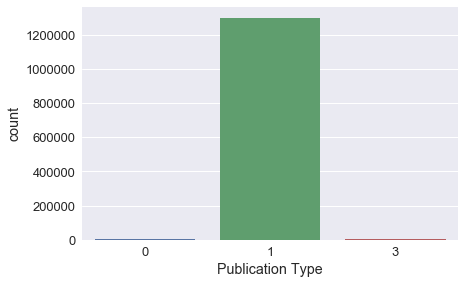

In [337]:
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Publication Type", data=df)

In [ ]:
# import seaborn as sns
# sns.set(style="darkgrid")
# ax = sns.countplot(x="Venue", data=df)

Text(0.5,0.98,'Distribution of Paper published in Years')

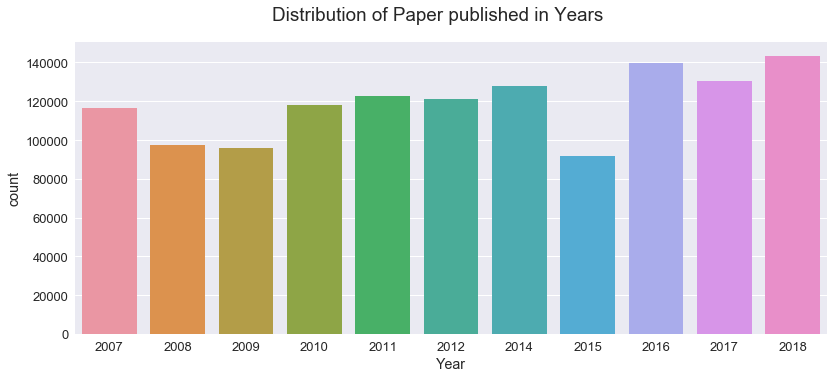

In [336]:
# paper publication throughout the period
plt.figure(figsize=(12,5))
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Year", data=df)
plt.suptitle("Distribution of Paper published in Years")

Text(0.5,0.98,'Number of paper published in each month')

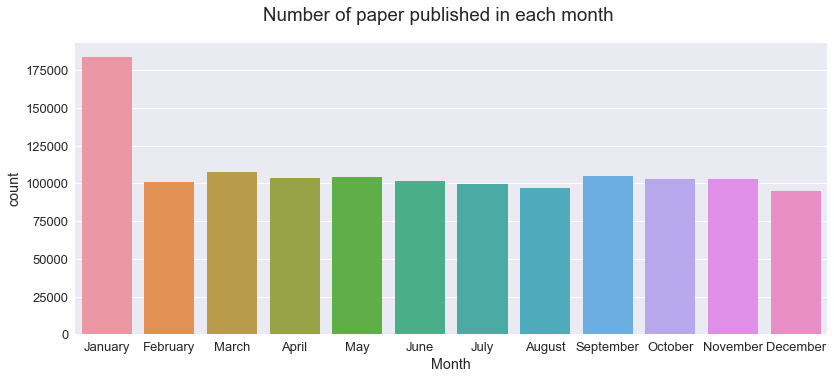

In [335]:
# paper publication around a year
plt.figure(figsize=(12,5))
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Month", data=df)
ax.set_xticklabels(["January","February","March", "April", "May", "June", "July", "August", "September", "October","November", "December"])
plt.suptitle("Number of paper published in each month")

### Analyzing Authors

In [296]:
max(df.Number_Of_authors)

500

In [341]:
df.sort_values(by=["Number_Of_authors"], ascending=False).head()

,Unnamed: 0,Authors,Conference,Citation_count,Date,Expected_count,Domain,Id,Journal,References,Title,Venue,Words,Year,Popularity,Month,Publication_Rank,Publication Type,Number_Of_authors
37996,244236,"[{'S': 1, 'AuId': 2237243105, 'AfN': 'universi...",NaN,23,2007-08-17,23,"[{'FId': 2779244929, 'FN': 'b factory'}, {'FId...",2136715807,"{'JN': 'phys rev lett', 'JId': 24807848}",NaN,measurement of cp violating asymmetries in b0 d d,Physical Review Letters,"['asymmetries', 'b0', 'cp', 'd', 'measurement'...",2007,-19.961,8,3.622,1,500
731958,402805,"[{'S': 1, 'AuId': 424305669, 'AfN': 'cern', 'A...",NaN,3,2014-01-01,3,"[{'FId': 207206121, 'FN': 'top quark'}, {'FId'...",1538855274,"{'JN': 'eur phys j', 'JId': 94052278}",NaN,measurement of the top quark mass in all jets ...,European Physical Journal C,"['7', 'collisions', 'events', 'jets', 'mass', ...",2014,-20.238,1,2.022,1,500
1050544,74447,"[{'AuId': 1977639945, 'S': 1, 'AuN': 'r aaij'}...",NaN,0,2017-07-19,0,"[{'FId': 46460574, 'FN': 'branching fraction'}...",2610959862,"{'JN': 'phys rev', 'JId': 133490392}",NaN,observation of the b d k π decay,Physical Review D,"['b', 'd', 'decay', 'k', 'observation', 'π']",2017,-19.896,7,1.801,1,500
948760,311676,"[{'AuId': 1977639945, 'S': 1, 'AuN': 'r aaij'}...",NaN,11,2016-02-10,11,"[{'FId': 2780789777, 'FN': 'dalitz plot'}, {'F...",2762185403,"{'JN': 'phys rev', 'JId': 133490392}","[2030690537, 2258584306, 2128881154, 210989610...",constraints on the unitarity triangle angle ga...,Physical Review D,"['0', 'angle', 'b', 'constraints', 'd', 'dalit...",2016,-20.380,2,1.801,1,500
1050610,74764,"[{'S': 1, 'AuId': 1977639945, 'AfN': 'cern', '...",NaN,0,2017-03-01,0,"[{'FId': 38976095, 'FN': 'asymmetry'}, {'FId':...",2743091279,"{'JN': 'phys rev', 'JId': 133490392}",NaN,measurement of the b production asymmetry and ...,Physical Review D,"['aaij', 'al', 'asymmetry', 'b', 'cp', 'decays...",2017,-19.898,3,1.801,1,500


In [342]:
df["Year"][24093]

2007

Text(0.5,0.98,'Number of authors for given paper')

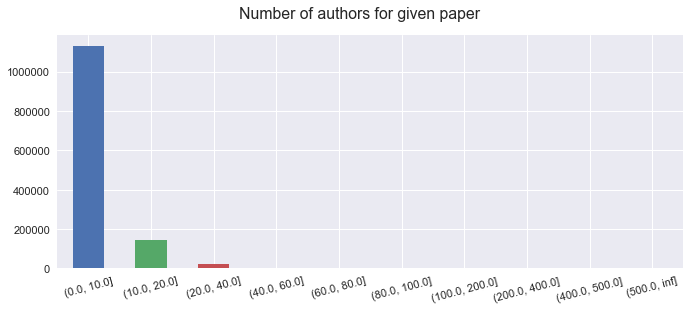

In [300]:
# Number of authors for the paper, Group data according to number of authors
bins = [0, 10, 20, 40, 60, 80, 100, 200, 400, 500, np.inf]
# author_groups = pd.cut(df["Number_Of_authors"], bins)
# df["author_groups"] = author_groups
plt.figure(figsize=(10,4))
sns.set(style="darkgrid",font_scale=1.1)
sss = pd.cut(df['Number_Of_authors'], bins=bins)
ax = sss.value_counts(sort=False).plot.bar(rot=15)
# sns.distplot(sss)

plt.suptitle("Number of authors for given paper")

In [301]:
sss.value_counts()

(0.0, 10.0]       1128460
(10.0, 20.0]       144911
(20.0, 40.0]        20813
(400.0, 500.0]       4007
(40.0, 60.0]         2604
(100.0, 200.0]       1326
(200.0, 400.0]        863
(60.0, 80.0]          769
(80.0, 100.0]         537
(500.0, inf]            0
Name: Number_Of_authors, dtype: int64

In [333]:
# obj = json.loads("[{'AuId': 2168721218, 'S': 1, 'AuN': 'emelia j benjamin'},]")
obj = ast.literal_eval(df["Authors"][24093])
print(len(obj))
print(json.dumps(obj, indent=2))
universities = { _obj["AfN"] for _obj in obj if "AfN" in _obj}
print(universities)

10
[
  {
    "AuId": 2600090029,
    "S": 1,
    "AuN": "bernard denis"
  },
  {
    "AuId": 1976173951,
    "S": 2,
    "AuN": "marcel ruetsch"
  },
  {
    "AuId": 2101003335,
    "S": 3,
    "AuN": "patrick strentz"
  },
  {
    "AuId": 2095743397,
    "S": 4,
    "AuN": "jean yves vogel"
  },
  {
    "AuId": 2108400148,
    "S": 5,
    "AuN": "francis guth"
  },
  {
    "AuId": 738814241,
    "S": 6,
    "AuN": "jean marc boyaval"
  },
  {
    "AuId": 1794191381,
    "S": 7,
    "AuN": "xavier pagnon"
  },
  {
    "AuId": 2109946559,
    "S": 8,
    "AuN": "jean francois ebelin"
  },
  {
    "AuId": 2306459608,
    "S": 9,
    "AuN": "isabelle gendre"
  },
  {
    "AuId": 2538426135,
    "S": 10,
    "AuN": "philippe perrin"
  }
]
set()


### Analyzing Domains

In [241]:
def get_num_domains(row):
    if not pd.isnull(row["Domain"]):
        json_obj = ast.literal_eval(row["Domain"])
        if json_obj:
            return len(json_obj)
    return 0

In [343]:
df["Domain_count"] = df.apply(lambda row:get_num_domains(row), axis = 1)

In [334]:
obj = ast.literal_eval(df["Domain"][2208])
print(json.dumps(obj, indent=2))
obj[0]["FId"]

[
  {
    "FId": 2777383355,
    "FN": "pivot shift test"
  },
  {
    "FId": 2778134712,
    "FN": "bundle"
  },
  {
    "FId": 2776141760,
    "FN": "hamstring"
  },
  {
    "FId": 2778434673,
    "FN": "anterior cruciate ligament"
  },
  {
    "FId": 2779974597,
    "FN": "clinical practice"
  },
  {
    "FId": 207821765,
    "FN": "instability"
  },
  {
    "FId": 141071460,
    "FN": "surgery"
  },
  {
    "FId": 71924100,
    "FN": "medicine"
  }
]


2777383355

In [249]:
df.sort_values(by=["Domain_count"], ascending=False).head()["Domain_count"]

119049    14
3170      14
34664     14
87797     14
59636     14
Name: Domain_count, dtype: int64

In [259]:
domain_dict = Counter()
for index, row in df.iterrows():
    if not pd.isnull(row["Domain"]):
        json_obj = ast.literal_eval(row["Domain"])
        if json_obj:
            for obj in json_obj:
                domain_dict[obj["FN"]] += 1

In [288]:
print(f"Number of unique domains: {len(domain_dict)}")
print(f"Top 20 most common domains: {json.dumps(domain_dict.most_common(20),indent=1)}")

Number of unique domains: 51188
Top 10 most common domains: [
 [
  "medicine",
  39935
 ],
 [
  "biology",
  27521
 ],
 [
  "chemistry",
  22224
 ],
 [
  "physics",
  12727
 ],
 [
  "internal medicine",
  11291
 ],
 [
  "inorganic chemistry",
  9327
 ],
 [
  "physical therapy",
  8530
 ],
 [
  "organic chemistry",
  7738
 ],
 [
  "immunology",
  7638
 ],
 [
  "psychology",
  7303
 ],
 [
  "diabetes mellitus",
  7147
 ],
 [
  "cardiology",
  6104
 ],
 [
  "biochemistry",
  6079
 ],
 [
  "surgery",
  5963
 ],
 [
  "photochemistry",
  5660
 ],
 [
  "molecular biology",
  5462
 ],
 [
  "analytical chemistry",
  5347
 ],
 [
  "genetics",
  5260
 ],
 [
  "pathology",
  5198
 ],
 [
  "virology",
  4917
 ]
]


In [25]:
outlink_map = {}
inlink_map = {}
df_new = df[df["References"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References"]
    ref_list = list(map(int,ref.strip("[]'").split(",")))
    outlink_map[row["Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Id"])
        inlink_map[ref] = listi

In [ ]:
def calculate_page_rank():
    count = 0
    page_year = {row["Id"]:row["Year"] for _t, row in df.iterrows()}
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink_map.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    page_rank = {}
    updated_page_rank = {}
    for index in df["Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                #ns = 0.15 + (0.85 * ns)
                ns = 0.15 + float(0.85) * (ns/avg_year_citation_count[page_year[key]])
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        max_score = max(page_rank.values())
        print(f"max score is {max_score}")
        page_rank = { index:score/max_score for index, score in page_rank.items()}
        return page_rank

In [ ]:
page_rank = calculate_page_rank()
print(max(page_rank.values()))
print(sum(page_rank.values()))

In [ ]:
df["page_rank"] = 0
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)
df["page_rank"][0:10]

In [ ]:
df.to_csv("ranked_processed_data.csv")

In [ ]:
# from sklearn.utils.extmath import softmax
# df["page_rank"]  = softmax(df["page_rank"].values())

In [ ]:
# df.to_csv("ranked_softmax_processed_data.csv")